In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from dependency_decoding import chu_liu_edmonds
from pathlib import Path
from collections import defaultdict
import warnings

In [2]:
sent = np.load("en.1.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [3]:
def count_correct(pred_heads, gold_heads):
    assert len(pred_heads) == len(gold_heads)
    # Do not count the root attachment at index 0 as correct
    return sum(pred == gold for pred, gold in zip(pred_heads, gold_heads)) - 1


In [4]:
T_proj_de = T_proj[:,:,4]



D = pd.DataFrame(T_proj_de)
D

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-8.62632,NaN,NaN,1.65635,2.938030,NaN,1.046870,0.814859,NaN,NaN,NaN,NaN
3,-0.47144,NaN,0.473582,NaN,0.027130,NaN,0.860477,1.450960,NaN,NaN,-0.227550,NaN
4,-7.83572,NaN,1.205030,2.77568,NaN,NaN,0.671676,1.222200,NaN,-2.041870,-0.072970,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-6.12050,NaN,-0.199320,2.44934,0.186358,NaN,NaN,2.168920,NaN,-1.689140,0.138240,NaN
7,-4.31718,NaN,-0.436383,2.50661,-0.264420,NaN,1.884740,NaN,NaN,-1.100350,0.233265,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,-0.245201,1.26849,0.562723,NaN,2.510390,3.834650,NaN,NaN,0.975684,NaN


In [5]:
np.nanmin(T_proj_de)

-8.6263199999999998

In [6]:
T_proj_de[2] = np.nanmin(T_proj_de)
T_proj_de[6] = np.nanmin(T_proj_de)
T_proj_de[9] = np.nanmin(T_proj_de)

pred_heads, tree_score = chu_liu_edmonds(T_proj_de)
gold_heads = np.concatenate([[-1], sent["heads"]])
print(pred_heads, gold_heads)
count_correct(pred_heads, gold_heads)

[-1, 0, 0, 6, 3, 0, 0, 3, 0, 0, 7, 0] [-1  3  3  4  5  0  7  5  7 10  7  5]


2

In [7]:
#import warnings
#warnings.filterwarnings('ignore', r"")

p = Path(".")
scores = defaultdict(list)
sent_lens = []
tree_scores = defaultdict(list)

def softmax(sentence_matrix, temperature=1.0):
    m_exp = np.exp(sentence_matrix/temperature)
    return (m_exp.T / np.nansum(m_exp, axis=1)).T

def l1_normalize(M):
    return (M.T / np.nansum(M, axis=1)).T

def eliminate_all_nan_vals(M_proj):
    M_proj[np.isnan(M_proj)] = np.nanmin(M_proj)
    
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore")
#        by_row = np.nanmax(M_proj, axis=1)
#        all_nan_rows = np.isnan(by_row)
#        M_proj[all_nan_rows] = np.nanmin(M_proj)

def eval_projection(M_proj, name):
    eliminate_all_nan_vals(M_proj)
    pred_heads_from_all, tree_score = chu_liu_edmonds(M_proj)
    scores[name].append(count_correct(pred_heads_from_all, gold_heads))
    tree_scores[name].append(tree_score)

def apply_softmax_per_row_per_lang(T_proj):
    for lang in range(T_proj.shape[2]):
        T_proj_lang = T_proj[:,:,lang]
        T_proj[:,:,lang] = softmax(T_proj_lang, temperature=1)
    
token_count = 0




for file in p.glob("*.npz"):
    sent = np.load(str(file))
    T_proj = sent['projection_tensor']
    
    #print(T_proj.shape[2])
    #if T_proj.shape[2] < 15:
    #    print(T_proj.shape[2])
    #    continue
    
    source_langs = sent['source_languages']
    
    apply_softmax_per_row_per_lang(T_proj)
    
    gold_heads = np.concatenate([[-1], sent["heads"]])
    for lang in range(T_proj.shape[2]):
        lang_name = source_langs[lang]
        
        T_proj_lang = T_proj[:,:,lang]
        T_proj_lang = np.where(np.isnan(T_proj_lang), np.nanmin(T_proj_lang), T_proj_lang)
        pred_heads, tree_score = chu_liu_edmonds(T_proj_lang)
        
        scores[lang_name].append(count_correct(pred_heads, gold_heads))
        tree_scores[lang_name].append(tree_score)
        
        
    # Aggregate measures
    good_lang_ids = [i for i, lang_name in enumerate(source_langs)
                     if lang_name in ["fr", "de", "es", "sv", "no", "da"]]
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_projection(np.nansum(T_proj, axis=2), "all_sum")
        eval_projection(np.nanmean(T_proj, axis=2), "all_mean")
        eval_projection(np.nanmax(T_proj, axis=2), "all_max")

        eval_projection(softmax(np.nansum(T_proj, axis=2)), "all_sum_softmax")
        eval_projection(softmax(np.nanmean(T_proj, axis=2)), "all_mean_softmax")

        eval_projection(l1_normalize(np.nansum(T_proj, axis=2)), "all_sum_l1")
    
    
    sent_lens.append(len(pred_heads) - 1)
    token_count += len(pred_heads) - 1

aggregated_scores = {k: sum(vals) for k, vals in scores.items()}
aggregated_tree_scores = {k: np.nansum(vals) for k, vals in tree_scores.items()}
print(token_count)
pd.DataFrame({"tree_score": pd.Series(aggregated_tree_scores), 
              "accuracy": pd.Series(aggregated_scores)})

/Users/zagic/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/Users/zagic/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


23686


,accuracy,tree_score
all_max,6526,1.703283e+04
all_mean,7870,1.015316e+04
all_mean_softmax,7829,1.876890e+03
all_sum,8494,5.313474e+04
all_sum_l1,8357,6.197521e+03
all_sum_softmax,8483,5.940104e+03
ar,188,3.948098e+02
bg,4200,8.150486e+03
cs,2678,5.502139e+03
da,3542,5.023820e+03


In [8]:
np.nansum([np.nan, np.nan])

0.0

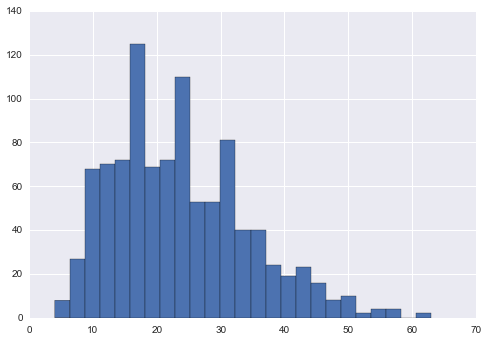

In [9]:
D = pd.DataFrame({"accuracy": np.array(scores["all_sum"])  / np.array(sent_lens), 
                  "tree_score": np.array(tree_scores["all_sum"]),
                  "norm_tree_score": np.array(tree_scores["all_sum"]) / np.array(sent_lens),
                  "sent_lens": np.array(sent_lens)}
                )

#for i in range(11):
#    print(D[D.accuracy > i / 10].sent_lens.mean())

D.sent_lens.hist(bins=25)
#D[D.sent_lens > 35].accuracy.mean()




In [10]:
sent['heads']

array([ 3,  3,  0,  5,  3,  9,  9,  9,  3, 11,  9,  9,  9, 15, 16,  9, 19,
       19, 16, 19, 15, 15, 25, 25, 16, 25, 28, 26, 15, 33, 32, 33, 15, 35,
       33, 37, 35, 37, 15])

In [13]:
x = np.zeros(M_norm.shape[1]) * np.nan
M_norm = np.vstack([x, M_norm])
chu_liu_edmonds(M_norm)

NameError: name 'M_norm' is not defined